# Natural Language Processing with RNNs - Toxic Comment Classification

1. Download and explore the dataset
2. Preprocess the data for training
3. Build an RNN model
4. Train and evaluate the model
5. Make predictions & submission


## Download and explore the dataset

1. Download the dataset from [Kaggle](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)
2. Load data into a pandas DataFrame
3. Explore the dataset


In [1]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p ../data

jigsaw-toxic-comment-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
DATA_DIR = "../data/jigsaw-toxic-comment-classification-challenge"

In [3]:
import pandas as pd

In [4]:
raw_df = pd.read_csv(DATA_DIR + "/train.csv.zip")
test_df = pd.read_csv(DATA_DIR + "/test.csv.zip")
sub_df = pd.read_csv(DATA_DIR + "/sample_submission.csv.zip")

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
raw_df.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
108526,442c32c7f8d98933,"""\n\nI have sent the following complaint to wi...",0,0,0,0,0,0
146373,2b3398651c2fb2ff,"""\nAs Father C, my former parish priest would ...",0,0,0,0,0,0
26718,46d096e760e55d08,"Not to mention, he's a nobody. He's his bigges...",0,0,0,0,0,0
51010,886d3d894af06673,August 2013 (UTC)\n\n Now about debunking such...,0,0,0,0,0,0
108936,4678847f7cbc4ae6,Appeal Again \n\n{{unblock==I would like to be...,0,0,0,0,0,0
116093,6cb96c2d03374709,Fine. But which ancient or medieval bridge had...,0,0,0,0,0,0
46725,7cdd8fc7847bead9,"""\n\nThis IP address is not static, and is the...",0,0,0,0,0,0
114784,65caadeb6926dc3b,"""\n\n INRConvert \n\n is the real architect be...",0,0,0,0,0,0
73665,c51f8d28a413e29b,I have lifted the autoblock.,0,0,0,0,0,0
67074,b3777f0e9d1aafae,a gentle warning \n\nBy now it should be evide...,0,0,0,0,0,0


In [7]:
target_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [8]:
for col in target_cols:
    print(raw_df[col].value_counts(normalize=True))

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64
severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64
obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64
threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64
insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64
identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64


In [9]:
from matplotlib import pyplot as plt

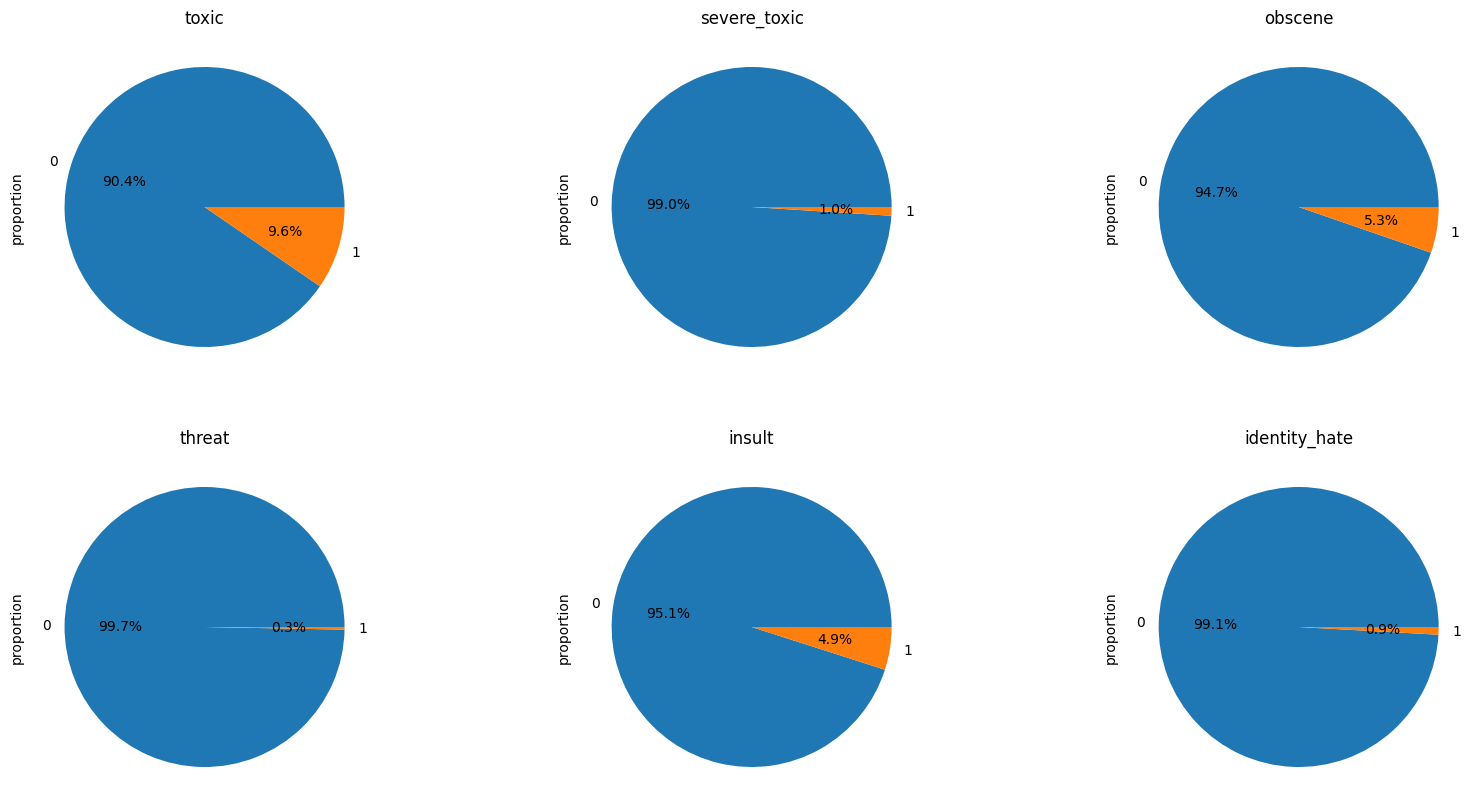

In [10]:
# Circle chart
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i, col in enumerate(target_cols):
    raw_df[col].value_counts(normalize=True).plot.pie(
        autopct="%1.1f%%", ax=ax[i // 3, i % 3], title=col
    )
plt.show()

## Preprocess the Dataset for Training

-   Create a vocabulary using TorchText
-   Create training and validation datasets
-   Create PyTorch DataLoader objects


In [13]:
# install TorchText
!pip install --upgrade pip
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [54]:
import torch
import torchtext

torchtext.disable_torchtext_deprecation_warning()
from torchtext.data import get_tokenizer

In [19]:
tokenizer = get_tokenizer(tokenizer="basic_english")

In [23]:
sample_comment = raw_df.comment_text.values[0]
tokenizer(sample_comment)[:10]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica']

### Build vocabulary


In [26]:
from torchtext.vocab import build_vocab_from_iterator

In [27]:
VOCAB_SIZE = 1500

In [28]:
# Special tokens
# UNK: Unknown token, PAD: Padding token, BOS: Beginning of sentence token, EOS: End of sentence token
UNK, PAD, BOS, EOS = "<unk>", "<pad>", "<bos>", "<eos>"

In [29]:
vocab = build_vocab_from_iterator(
    map(tokenizer, raw_df.comment_text.values),
    specials=[UNK, PAD, BOS, EOS],
    max_tokens=VOCAB_SIZE,
)

In [31]:
vocab.set_default_index(vocab[UNK])

In [33]:
sample_indices = vocab.lookup_indices(tokens=tokenizer(sample_comment))
sample_indices[:10]

[669, 87, 5, 142, 144, 187, 41, 665, 0, 0]

In [35]:
sample_comment_reconstructed = " ".join(vocab.lookup_tokens(sample_indices[:10]))
sample_comment_reconstructed

'explanation why the edits made under my username <unk> <unk>'

### Create training and validation datasets

-   Define a custom PyTorch Dataset
-   Pass raw data into the Dataset
-   Split the PyTorch Dataset


In [41]:
comment_tokens = list(map(tokenizer, raw_df.comment_text.values))
max_len = max(map(len, comment_tokens))
min_len = min(map(len, comment_tokens))
mean_len = sum(map(len, comment_tokens)) / len(comment_tokens)
max_len, min_len, mean_len

(4948, 1, 79.58488071140746)

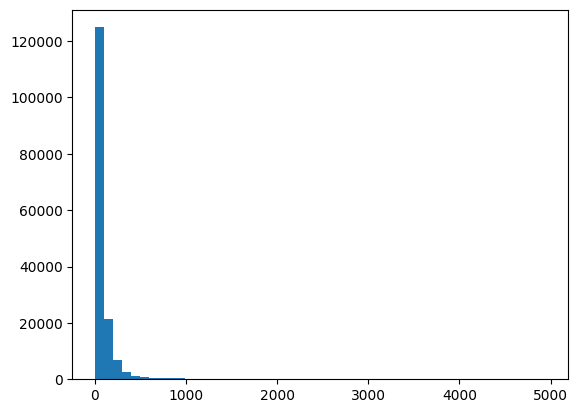

In [47]:
plt.hist(list(map(len, comment_tokens)), bins=50)
plt.show()

In [50]:
MAX_LEN = 150

In [71]:
# Function to pad tokens to MAX_LEN
def pad_tokens(tokens):
    if len(tokens) > MAX_LEN - 2:  # Account for BOS and EOS tokens
        return tokens[: MAX_LEN - 2]
    else:
        return tokens + [vocab[PAD]] * (MAX_LEN - len(tokens) - 2)

In [72]:
# BOS and EOS tokens
def wrap_tokens(tokens):
    return [vocab[BOS]] + tokens + [vocab[EOS]]

In [73]:
pad_tokens(sample_indices)[:10]

[669, 87, 5, 142, 144, 187, 41, 665, 0, 0]

In [52]:
from torch.utils.data import Dataset
from typing import Any

In [79]:
class JigsawDataset(Dataset):
    def __init__(self, df, is_test=False) -> None:
        super().__init__()
        self.df = df
        self.is_test = is_test

    def __getitem__(self, index) -> Any:
        # Get the comment text
        comment = self.df.comment_text.values[index]
        # Tokenize the comment
        tokens = tokenizer(comment)
        # Convert tokens to indices
        indices = vocab.lookup_indices(tokens)
        # Pad the indices
        indices = pad_tokens(indices)
        # Wrap the indices with BOS and EOS tokens
        indices = wrap_tokens(indices)
        # Convert the indices to tensor
        indices = torch.tensor(indices)
        # If it is test dataset, return only indices
        if self.is_test:
            return indices, torch.zeros(len(target_cols))
        # Otherwise, return indices and target
        target = self.df[target_cols].values[index]
        return indices, torch.tensor(target).float()

    def __len__(self) -> int:
        return len(self.df)

In [80]:
raw_ds = JigsawDataset(df=raw_df)

In [67]:
raw_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [81]:
raw_ds[0]

(tensor([   2,  669,   87,    5,  142,  144,  187,   41,  665,    0,    0, 1289,
           98,  331,   29,   59,    0,   11,   33,    0,    6,   63,    0,   23,
           73,    0,  160,    8,    0,   47,  132, 1169,    0,    0,    4,   10,
           57,   72,   11,   33,  255,    5,  371,   43,    5,   52,   40,  157,
            8,   11,   83,    0,  101,    4,    0,    4,    0,    4,    0,    4,
         1124,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

In [82]:
from torch.utils.data import random_split

In [83]:
VAL_FRAC = 0.25

In [85]:
train_ds, val_ds = random_split(
    raw_ds, [1 - VAL_FRAC, VAL_FRAC], generator=torch.Generator().manual_seed(42)
)

In [86]:
len(train_ds), len(val_ds), len(raw_ds)

(119679, 39892, 159571)

In [87]:
test_ds = JigsawDataset(df=test_df, is_test=True)

In [89]:
test_df.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [88]:
test_ds[0]

(tensor([   2,    0,  638,    0,  651,   14,   71,    0,   95,   12,   11,  171,
          361,   25,    0,   91,   32,   12,   10,    0,   12, 1490,    0,    4,
            4,    4,    8,   70,  638,    0,    0,    0,  692,    0,   10,  107,
           12,    7,    0,   41,  421,   12,  701,    0,   48,    4,    0,  651,
           14,   49,    0,   17,    0,  670,  441,    4,  445,    0,   15,  334,
           23,  169,    4,   10,    0,   14,  253,    0,   64,    0,   61,   36,
           13,    0,  173,    4,    4,    4,    0,  692,    0,  107,  228,  162,
          492,   97,    4,    6,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,  

### Create PyTorch DataLoader objects


In [93]:
import os
from torch.utils.data import DataLoader

In [101]:
BATCH_SIZE = 32

In [178]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
	pin_memory=True,
)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE * 2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE * 2, pin_memory=True)

In [109]:
for batch in train_dl:
    b_in, b_tgt = batch
    print(b_in.shape, b_tgt.shape)
    break

torch.Size([32, 150]) torch.Size([32, 6])


## Build an RNN model

1. Implement the RNN model using PyTorch
2. Pass a batch of data into the model


In [112]:
import torch.nn as nn

In [113]:
emb_layer = nn.Embedding(
    num_embeddings=VOCAB_SIZE,
    embedding_dim=256,
    padding_idx=vocab[PAD],
    max_norm=1.0,
    norm_type=2.0,
)

In [127]:
rnn_layer = nn.RNN(
    input_size=256,
    hidden_size=128,
    num_layers=2,
    batch_first=True,
    dropout=0.2,
    bidirectional=True,
)

In [128]:
for batch in train_dl:
    b_in, _ = batch
    emb_out = emb_layer(b_in)
    print(emb_out.shape)
    # hn is the last hidden state => (num_layers * num_directions, batch, hidden_size)
    rnn_out, hn = rnn_layer(emb_out)
    print(rnn_out.shape, hn.shape)
    break

torch.Size([32, 150, 256])
torch.Size([32, 150, 256]) torch.Size([4, 32, 128])


In [129]:
# Install PyTorch Lightning
!pip install pytorch-lightning --quiet

In [130]:
import pytorch_lightning as pl

In [193]:
class JigsawModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(
            num_embeddings=VOCAB_SIZE,
            embedding_dim=256,
            padding_idx=vocab[PAD],
            max_norm=1.0,
            norm_type=2.0,
        )
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=1,
            batch_first=True,
            # dropout=0.2,
            # bidirectional=True,
        )
        self.linear = nn.Linear(in_features=128, out_features=len(target_cols))
        self.lr = 1e-3
        self.validation_step_losses = []

    def forward(self, x):
        out = self.emb(x)
        out, hn = self.lstm(out)
        out = torch.relu(out[:, -1, :])
        return self.linear(out)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = nn.BCEWithLogitsLoss()(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = nn.BCEWithLogitsLoss()(y_hat, y)
        self.validation_step_losses.append(loss)
        return loss.item()

    def on_validation_epoch_end(self):
        avg_loss = sum(self.validation_step_losses) / len(self.validation_step_losses)
        self.log("val_loss", avg_loss)
        self.validation_step_losses.clear()  # free memory

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        X, _ = batch
        y_hat = self(X)
        return y_hat

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [194]:
model = JigsawModel()

In [195]:
for batch in train_dl:
    b_in, _ = batch
    out = model(b_in)
    print(out.shape)
    probs = torch.sigmoid(out)
    loss = nn.BCELoss()(probs, torch.zeros_like(probs))
    print(loss)
    break

torch.Size([32, 6])
tensor(0.7042, grad_fn=<BinaryCrossEntropyBackward0>)


## Train and evaluate the model


In [196]:
trainer = pl.Trainer(max_epochs=3, accelerator="mps", log_every_n_steps=1)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [197]:
tuner = pl.tuner.tuning.Tuner(trainer)
tuner.lr_find(model, train_dl, val_dl)

/Users/macbook/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/macbook/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.005754399373371567
Restoring states from the checkpoint path at /Users/macbook/tranmq/ML-DL-GenAI/NLP/.lr_find_76c92c0b-80ef-427b-a7b3-c17d82bf2f68.ckpt
Restored all states from the checkpoint at /Users/macbook/tranmq/ML-DL-GenAI/NLP/.lr_find_76c92c0b-80ef-427b-a7b3-c17d82bf2f68.ckpt


In [198]:
model.lr

0.005754399373371567

In [199]:
trainer.fit(model, train_dl, val_dl)


  | Name   | Type      | Params | Mode 
---------------------------------------------
0 | emb    | Embedding | 384 K  | train
1 | lstm   | LSTM      | 197 K  | train
2 | linear | Linear    | 774    | train
---------------------------------------------
582 K     Trainable params
0         Non-trainable params
582 K     Total params
2.330     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/macbook/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Make predictions & submission

In [200]:
test_df.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [202]:
for batch in test_dl:
	b_in, _ = batch
	out = model(b_in)
	print(out.shape)
	break

torch.Size([64, 6])


In [203]:
test_preds = trainer.predict(model, test_dl)

/Users/macbook/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [230]:
test_probs = []
for pred in test_preds:
	test_probs.append(torch.sigmoid(pred))

In [231]:
test_probs = torch.cat(test_probs, dim=0).detach().cpu().numpy()
test_probs.shape

(153164, 6)

In [233]:
sub_df[target_cols] = test_probs

In [235]:
sub_df.to_csv(DATA_DIR + "/submission.csv", index=False)

In [236]:
!head $DATA_DIR/submission.csv

id,toxic,severe_toxic,obscene,threat,insult,identity_hate
00001cee341fdb12,0.9929817,0.3322756,0.96769965,0.023225563,0.8877563,0.11585725
0000247867823ef7,0.007570883,1.7184737e-05,0.0015506027,8.4164814e-05,0.0023269686,0.00016333896
00013b17ad220c46,0.010984155,4.0363506e-05,0.0020591326,0.00013076756,0.0034054886,0.00028812917
00017563c3f7919a,0.0071801036,1.7057218e-05,0.0014658037,9.304003e-05,0.0022347346,0.00015304318
00017695ad8997eb,0.025553629,0.00016132137,0.004577222,0.00036859862,0.007344992,0.0007541548
0001ea8717f6de06,0.011160872,7.141404e-05,0.002954982,0.0003499975,0.004084922,0.00039900767
00024115d4cbde0f,0.0060905037,1.4723866e-05,0.0011405837,7.259435e-05,0.0019417846,0.00013223552
000247e83dcc1211,0.21870257,0.009367879,0.06393255,0.011204858,0.07778899,0.016418695
00025358d4737918,0.0049976967,1.3505198e-05,0.0010186441,6.211136e-05,0.001696165,0.00012199043


In [259]:
sample_df = raw_df.sample(10)
sample_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
44629,774600da7108457c,Hi Friend! \n\nWill you be my wikipedia mentor?,0,0,0,0,0,0
1550,042c88029647f67d,"Ahh, I am glad to say that I have worked out t...",0,0,0,0,0,0
86320,e6e2c37e52347437,I've added in some replies. Thanks for the hel...,0,0,0,0,0,0
121923,8c447ec9f6b550bd,"""\nIn fact, I think we can substantially curta...",0,0,0,0,0,0
133164,c86e6ecc8340b2de,"I'm afraid, this is not eligible for DYK, beca...",0,0,0,0,0,0
151626,801b45543473f467,"""\n\n Military history WikiProject Newsletter,...",0,0,0,0,0,0
36393,6136aae4944b9004,"""\n\n Sorry and =\nSorry about calling you an ...",0,0,0,0,0,0
66380,b198fbb4be221c24,I think this page should discuss some of the i...,0,0,0,0,0,0
23074,3cfe953c66ddefc9,The poor grade his son got in elementery mathe...,0,0,0,0,0,0
63111,a8d972eace59cf9a,vis-a-vis the Sabbath,0,0,0,0,0,0


In [260]:
sample_ds = JigsawDataset(df=sample_df)

In [261]:
sample_dl = DataLoader(sample_ds, batch_size=10)

In [265]:
sample_preds = trainer.predict(model, sample_dl)
sample_probs = torch.cat([torch.sigmoid(pred) for pred in sample_preds], dim=0).detach().cpu().numpy() # need to call cat to concatenate the list of tensors because preds is a list of tensors of shape (batch_size, num_classes) and we need to concatenate them along the batch_size dimension to get the probabilities of shape (num_samples, num_classes)
sample_probs = (sample_probs > 0.5).astype(int)

/Users/macbook/.local/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [266]:
sample_df[target_cols] = sample_probs
sample_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
44629,774600da7108457c,Hi Friend! \n\nWill you be my wikipedia mentor?,0,0,0,0,0,0
1550,042c88029647f67d,"Ahh, I am glad to say that I have worked out t...",0,0,0,0,0,0
86320,e6e2c37e52347437,I've added in some replies. Thanks for the hel...,0,0,0,0,0,0
121923,8c447ec9f6b550bd,"""\nIn fact, I think we can substantially curta...",0,0,0,0,0,0
133164,c86e6ecc8340b2de,"I'm afraid, this is not eligible for DYK, beca...",0,0,0,0,0,0
151626,801b45543473f467,"""\n\n Military history WikiProject Newsletter,...",0,0,0,0,0,0
36393,6136aae4944b9004,"""\n\n Sorry and =\nSorry about calling you an ...",0,0,0,0,0,0
66380,b198fbb4be221c24,I think this page should discuss some of the i...,0,0,0,0,0,0
23074,3cfe953c66ddefc9,The poor grade his son got in elementery mathe...,0,0,0,0,0,0
63111,a8d972eace59cf9a,vis-a-vis the Sabbath,0,0,0,0,0,0
